# Demo application

This notebook builds a model for the demo provided in lecture 1 of the Packt ML with scikit-learn course.

The dataset is the [wine quality](http://archive.ics.uci.edu/ml/datasets/Wine+Quality) dataset from the UCI ML repository. There are 11 features native to the (two original&mdash;one for red, one for white) dataset(s):

1. fixed acidity 
2. volatile acidity 
3. citric acid 
4. residual sugar 
5. chlorides 
6. free sulfur dioxide 
7. total sulfur dioxide 
8. density 
9. pH 
10. sulphates 
11. alcohol 

We add a 12th feature and combine the datasets into one:

    red - whether the wine is red

__Target: quality__ (score between 0 and 10). Note that this could be considered either a classification or regression task, but makes more sense to treat as regression as the accuracy loss of estimating two adjacent classes, say '6' vs. '7', would otherwise be penalized as severely as estimating '1' vs. '10'. Regression scoring metrics help us rectify this by treating the target as a continuum rather than discrete classes.

## References

The original dataset donor:

    P. Cortez, A. Cerdeira, F. Almeida, T. Matos and J. Reis. 
    Modeling wine preferences by data mining from physicochemical properties. 
    In Decision Support Systems, Elsevier, 47(4): 547-553, 2009.

In [1]:
import pandas as pd

# read both datasets
red = pd.read_table('data/winequality-red.csv', sep=';')
white = pd.read_table('data/winequality-white.csv', sep=';')

# add new feature and concat the two
red['red'] = 1.
white['red'] = 0.
data = red.append(white, ignore_index=True).drop_duplicates()

# view the combined
data.head()

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality,red
0,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5,1.0
1,7.8,0.88,0.00,2.6,0.098,25.0,67.0,0.9968,3.20,0.68,9.8,5,1.0
2,7.8,0.76,0.04,2.3,0.092,15.0,54.0,0.9970,3.26,0.65,9.8,5,1.0
3,11.2,0.28,0.56,1.9,0.075,17.0,60.0,0.9980,3.16,0.58,9.8,6,1.0
5,7.4,0.66,0.00,1.8,0.075,13.0,40.0,0.9978,3.51,0.56,9.4,5,1.0


### Write the whole dataset

Write it out so we can use it in the API section

In [2]:
data.to_csv('data/allwine.csv', index=False, header=True)

### Pre-split examination

Is there natural class imbalance?

In [3]:
data.red.value_counts()

0.0    3961
1.0    1359
Name: red, dtype: int64

It would appear that white wines are about 3 times as prevalent in this dataset. We'll want to make sure to stratify our split on the `red` feature.

Since our target, `quality`, is 100% subjective, there is significant bias in our dataset. In that sense, we're really predicting the quality as judged by whomever created this dataset to begin with... is there an underlying bias in quality scores stratifed by red/white?

red
0.0    AxesSubplot(0.125,0.125;0.775x0.755)
1.0    AxesSubplot(0.125,0.125;0.775x0.755)
Name: quality, dtype: object

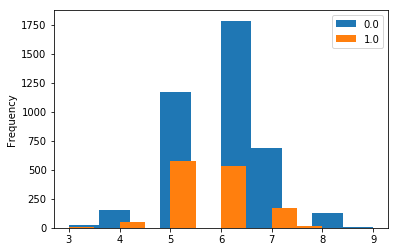

In [4]:
from matplotlib import pyplot as plt
%matplotlib inline

groups = data.groupby('red')
groups.quality.plot.hist(legend=True)

In [5]:
import numpy as np

groups.apply(lambda g: g.quality.median())

red
0.0    6.0
1.0    6.0
dtype: float64

In [6]:
groups.apply(lambda g: g.quality.mean())

red
0.0    5.854835
1.0    5.623252
dtype: float64

Visually, it does not look like there is any major discrepancy in the quality ratings between red and white, and the medians are equal. White wines do seem to have a larger variance and have a slightly higher mean.

In [7]:
# pop the y off the data
y = data.pop('quality')

# Split our dataset

Always gotta split...

In [8]:
from sklearn.model_selection import train_test_split
import numpy as np

# for replicability
seed = 42

# make sure to stratify on the 'red' feature!
X_train, X_test, y_train, y_test = train_test_split(data, y, test_size=0.3, 
                                                    random_state=seed,
                                                    stratify=data.red)

# reset the indices
X_train.index = np.arange(X_train.shape[0])
X_test.index = np.arange(X_test.shape[0])

print(X_train.shape)
X_train.head()

(3724, 12)


,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,red
0,9.1,0.25,0.34,2.0,0.071,45.0,67.0,0.99769,3.44,0.86,10.2,1.0
1,5.5,0.21,0.25,1.2,0.040,18.0,75.0,0.99006,3.31,0.56,11.3,0.0
2,5.8,0.31,0.31,7.5,0.052,55.0,230.0,0.99490,3.19,0.46,9.8,0.0
3,7.7,0.28,0.33,6.7,0.037,32.0,155.0,0.99510,3.39,0.62,10.7,0.0
4,7.3,0.19,0.27,13.9,0.057,45.0,155.0,0.99807,2.94,0.41,8.8,0.0


# Data cleaning

## 1: Any missing values?

In [9]:
X_train.isnull().sum()

fixed acidity           0
volatile acidity        0
citric acid             0
residual sugar          0
chlorides               0
free sulfur dioxide     0
total sulfur dioxide    0
density                 0
pH                      0
sulphates               0
alcohol                 0
red                     0
dtype: int64

## 2: Any major outliers?

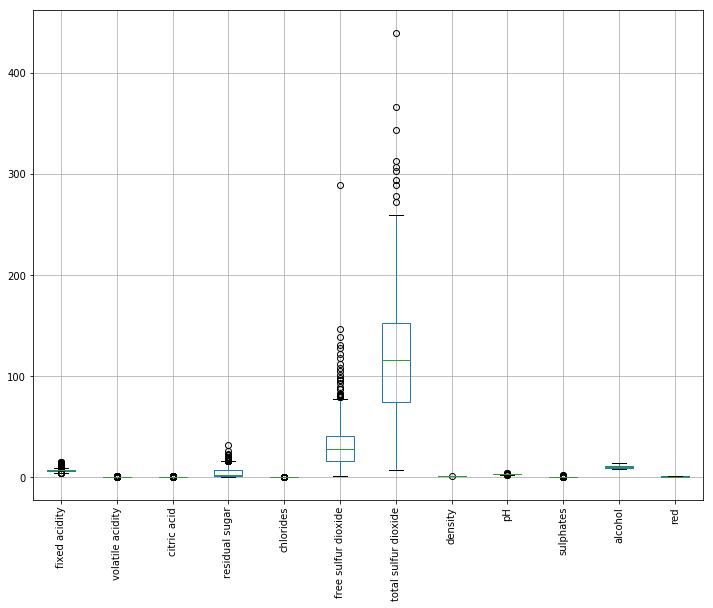

In [10]:
X_train.boxplot(figsize=(12, 9), rot=90)

OK, *some* of the features have massive skewness issues, and others have big outliers. Let's pare down the features that are throwing off the scale.

### Handle less-skewed features

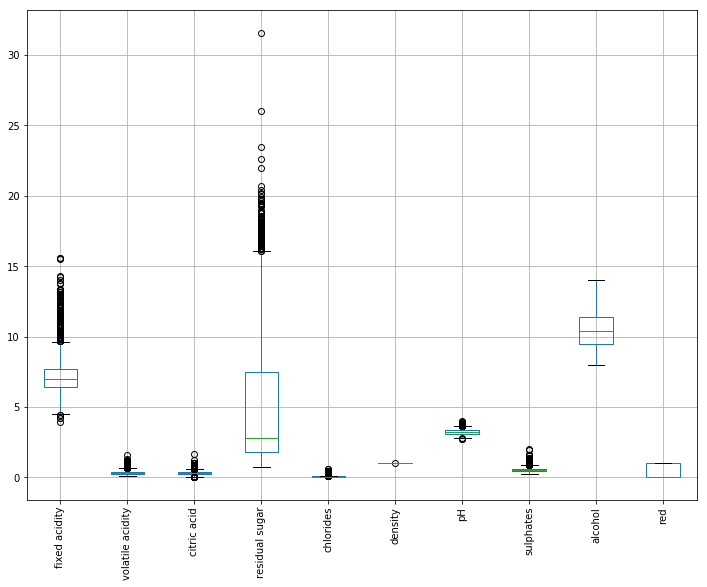

In [11]:
skewed = ['free sulfur dioxide', 'total sulfur dioxide']
X_train.boxplot(column=[x for x in X_train.columns 
                        if x not in skewed], 
                figsize=(12, 9), rot=90)

There is one huge outlier that might need some attention.


In [12]:
X_train.sort_values('residual sugar', ascending=False).head(1)

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,red
2539,7.9,0.33,0.28,31.6,0.053,35.0,176.0,1.0103,3.15,0.38,8.8,0.0


The other features in that example seem to be in line with the expectated values. Since it's likely the measurement was not the result of erroneous data, it could be valuable to leave in.

### Handle more-skewed features

Both of the features noted above are skewed right (Poisson). This means any Gaussian assumptions we could make about the dataset (i.e., "mean" being valuable) do not necessarily hold true. We'll have to consider this in future transformations.

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x1a180c2f60>,
        <matplotlib.axes._subplots.AxesSubplot object at 0x1a185742b0>]], dtype=object)

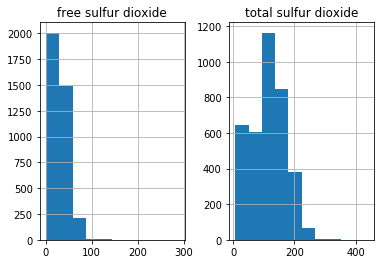

In [13]:
X_train[['free sulfur dioxide', 'total sulfur dioxide']].hist()

## 3 - Multicollinearity?

In [14]:
import seaborn as sns

# correlation matrix
corr = X_train.corr()

# color map (https://stackoverflow.com/questions/39409866/correlation-heatmap)
cmap = cmap=sns.diverging_palette(5, 250, as_cmap=True)

def magnify():
    return [dict(selector="th",
                 props=[("font-size", "7pt")]),
            dict(selector="td",
                 props=[('padding', "0em 0em")]),
            dict(selector="th:hover",
                 props=[("font-size", "12pt")]),
            dict(selector="tr:hover td:hover",
                 props=[('max-width', '200px'),
                        ('font-size', '12pt')])
           ]

corr.style.background_gradient(cmap, axis=1)\
    .set_properties(**{'max-width': '80px', 'font-size': '10pt'})\
    .set_caption("Hover to magify")\
    .set_precision(2)\
    .set_table_styles(magnify())

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,red
fixed acidity,1,0.2,0.34,-0.1,0.28,-0.28,-0.31,0.49,-0.29,0.29,-0.11,0.47
volatile acidity,0.2,1,-0.38,-0.17,0.36,-0.34,-0.4,0.31,0.24,0.22,-0.071,0.65
citric acid,0.34,-0.38,1,0.14,0.073,0.11,0.18,0.08,-0.35,0.055,0.015,-0.18
residual sugar,-0.1,-0.17,0.14,1,-0.12,0.4,0.49,0.5,-0.24,-0.19,-0.3,-0.33
chlorides,0.28,0.36,0.073,-0.12,1,-0.19,-0.28,0.37,0.011,0.43,-0.27,0.5
free sulfur dioxide,-0.28,-0.34,0.11,0.4,-0.19,1,0.72,0.0051,-0.13,-0.2,-0.17,-0.46
total sulfur dioxide,-0.31,-0.4,0.18,0.49,-0.28,0.72,1,-0.001,-0.22,-0.28,-0.24,-0.69
density,0.49,0.31,0.08,0.5,0.37,0.0051,-0.001,1,0.029,0.28,-0.68,0.44
pH,-0.29,0.24,-0.35,-0.24,0.011,-0.13,-0.22,0.029,1,0.16,0.1,0.31
sulphates,0.29,0.22,0.055,-0.19,0.43,-0.2,-0.28,0.28,0.16,1,-0.02,0.49


It appears there are several features here which are highly correlated. There are several considerations we may have to make:

1. For parametric models, we may have to select out the more informative features to reduce cross-correlations

2. We could use PCA to weed out correlations and reduce the feature space to concept space

# Transformers

Let's create a selective PCA transformer that will apply to all but the binary feature, however first...

### Pre-PCA: *SCALE!*

Computing PCA on data on varying scales is a recipe for disaster!

In [15]:
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.utils.validation import check_is_fitted
from sklearn.preprocessing import RobustScaler

class BaseDFTransformer(BaseEstimator, TransformerMixin):
    @staticmethod
    def _check_input(X):
        if not isinstance(X, pd.DataFrame):
            raise TypeError("X must be a DataFrame")
        return X
    

class SelectiveScaler(BaseDFTransformer):
    def __init__(self, scaler=RobustScaler(), features=None):
        self.scaler = scaler
        self.features = features
        
    def fit(self, X, y=None):
        X = self._check_input(X)
        
        # subset, fit
        if self.features:
            self.features_ = self.features
        else:
            self.features_ = X.columns
            
        # fit
        self.scaler.fit(X[self.features_])
        return self
        
    def transform(self, X):
        check_is_fitted(self, 'features_')
        
        # subset, transform
        trans = self.scaler.transform(X[self.features_])
        trans_df = pd.DataFrame.from_records(data=trans,
                                             columns=self.features_)
        
        # if there are any remaining, re-append them...
        remaining = [c for c in X.columns if c not in self.features_]
        if remaining:
            reappend = X[remaining]
            trans_df.index = reappend.index
            trans_df = pd.concat([trans_df, reappend], axis=1)
        
        # return the original order
        return trans_df[X.columns]

In [16]:
# fit on all but 'red'
scaler = SelectiveScaler(features=[c for c in X_train.columns if c != 'red'])
scaler.fit(X_train)

X_train_scaled = scaler.transform(X_train)
X_train_scaled.head()

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,red
0,1.615385,-0.236111,0.214286,-0.140351,0.857143,0.68,-0.628205,0.671111,1.045455,2.058824,-0.105263,1.0
1,-1.153846,-0.458333,-0.428571,-0.280702,-0.250000,-0.40,-0.525641,-1.024444,0.454545,0.294118,0.473684,0.0
2,-0.923077,0.097222,0.000000,0.824561,0.178571,1.08,1.461538,0.051111,-0.090909,-0.294118,-0.315789,0.0
3,0.538462,-0.069444,0.142857,0.684211,-0.357143,0.16,0.500000,0.095556,0.818182,0.647059,0.157895,0.0
4,0.230769,-0.569444,-0.285714,1.947368,0.357143,0.68,0.500000,0.755556,-1.227273,-0.588235,-0.842105,0.0


### Selective (non-binary feature) PCA transformer:

In [17]:
from sklearn.decomposition import PCA

class SelectivePCA(BaseDFTransformer):
    def __init__(self, binary_features=None, n_components=None, 
                 whiten=False, component_prefix='PC'):
        self.binary_features = binary_features
        self.n_components = n_components
        self.whiten = whiten
        self.component_prefix = component_prefix
    
    def _get_component_names(self, X):
        return ["%s%i" % (self.component_prefix, i) 
                for i in range(X.shape[1])]
            
    def fit(self, X, y=None):
        X = self._check_input(X)
        
        binfeat = self.binary_features
        if binfeat:
            sbin = set(binfeat)
            fitcols = [c for c in X.columns if c not in sbin]
        else:
            fitcols = X.columns.tolist()
            
        # fit the PCA on fitcols
        self.pca_ = PCA(n_components=self.n_components,
                        whiten=self.whiten).fit(X[fitcols])
        
        self.fit_cols_ = fitcols
        return self
    
    def loading_matrix(self):
        check_is_fitted(self, 'fit_cols_')
        comp = self.pca_.components_
        return pd.DataFrame.from_records(data=comp,
                                         columns=self.fit_cols_,
                                         index=self._get_component_names(comp))
        
    def transform(self, X):
        check_is_fitted(self, 'fit_cols_')
        X = self._check_input(X)  # no copy needed
        
        # ensure all the columns match up
        binfeat = self.binary_features
        scols = set(X.columns.tolist())
        if binfeat:
            assert all(b in scols for b in binfeat)
        assert all(c in scols for c in self.fit_cols_)
        
        # do transformation to np.array
        trans = self.pca_.transform(X[self.fit_cols_])
        df_trans = pd.DataFrame.from_records(data=trans, 
                                             columns=self._get_component_names(trans))
        
        # select out the binary features, reset the index, append
        if binfeat:
            binary = X[binfeat]
            df_trans.index = binary.index
            df_trans = pd.concat([df_trans, binary], axis=1)
            
        return df_trans

In [18]:
# test it out
pca = SelectivePCA(binary_features=['red']).fit(X_train_scaled)
pca.transform(X_train_scaled).head()

,PC0,PC1,PC2,PC3,PC4,PC5,PC6,PC7,PC8,PC9,PC10,red
0,1.601629,0.481668,-0.565305,0.012788,1.941657,-0.493302,-0.388137,1.002314,0.535587,0.491454,0.016169,1.0
1,-1.004672,-1.252941,-0.578970,1.311027,0.184479,-0.155147,-0.497571,-0.308330,-0.269669,0.102833,0.108812,0.0
2,-1.230649,0.368067,1.654421,0.256331,-0.009889,-0.035859,0.548411,0.284103,-0.296786,-0.292353,-0.175153,0.0
3,-0.454287,0.207710,-0.117241,-0.283813,1.063304,0.157453,-0.114466,0.317726,0.300698,-0.470730,0.175684,0.0
4,-0.719030,1.320876,1.566177,-1.001509,-0.596372,-0.859892,-0.687796,-0.509744,0.089844,0.234341,-0.041634,0.0


See which components are required to get up to a high level of explained variability

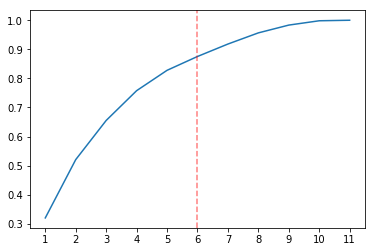

Cumulative explained variance at 6 components: 0.91817


In [19]:
explained_var = np.cumsum(pca.pca_.explained_variance_ratio_)
thresh = 0.90

x_axis = np.arange(len(pca.fit_cols_)) + 1
plt.plot(x_axis, explained_var)

# At which point to cut off?
minexp = np.where(explained_var > thresh)[0][0]
plt.axvline(x=minexp, linestyle='dashed', color='red', alpha=0.5)
plt.xticks(x_axis)
plt.show()

print("Cumulative explained variance at %i components: %.5f" % (minexp, explained_var[minexp]))

### Observe the loading matrix

We can colorize like we did with the corr plot.

In [20]:
lmat = pca.loading_matrix().T

lmat.style.background_gradient(cmap, axis=1)\
    .set_properties(**{'max-width': '80px', 'font-size': '10pt'})\
    .set_caption("Hover to magify")\
    .set_precision(2)\
    .set_table_styles(magnify())

,PC0,PC1,PC2,PC3,PC4,PC5,PC6,PC7,PC8,PC9,PC10
fixed acidity,0.34,0.33,-0.41,-0.5,-0.02,-0.23,0.0034,0.34,0.34,-0.16,0.23
volatile acidity,0.32,-0.35,0.056,-0.4,-0.12,0.35,0.64,-0.091,-0.21,0.038,0.066
citric acid,0.022,0.69,-0.27,0.24,0.033,0.55,0.16,-0.036,-0.22,0.1,0.0018
residual sugar,-0.12,0.24,0.41,-0.32,0.1,0.18,-0.12,-0.58,0.36,-0.013,0.37
chlorides,0.72,0.098,0.38,0.43,-0.3,-0.032,-0.049,0.011,0.18,-0.074,0.019
free sulfur dioxide,-0.19,0.18,0.36,0.052,0.14,-0.16,0.42,0.4,0.29,0.58,0.0063
total sulfur dioxide,-0.23,0.22,0.36,0.013,0.082,-0.087,0.33,0.22,-0.1,-0.76,-0.072
density,0.19,0.15,0.23,-0.4,0.19,0.15,-0.26,0.045,-0.0099,0.071,-0.77
pH,0.032,-0.32,0.047,0.11,0.4,0.58,-0.24,0.44,0.28,-0.14,0.2
sulphates,0.33,0.0056,-0.077,0.15,0.81,-0.3,0.15,-0.24,-0.16,0.00053,0.064


#### Reading a loading matrix:

Think of a "principal component" as a "concept." For instance, if this were movies, a component could represent something as abstract as a "dark atmosphere," and for wine, it could mean something as specific as the acidity (across all features). The values represent how high a feature "loads" on a components.

Many of the "acidic" features ('fixed acidity', 'volatile acidity' and 'chlorides') load high on PC0, so perhaps this component represents "acidity and chlorides." Notably, PC1 also loads high with acidic features, but loads *extremely* negatively for "volatile acidity," so this one might relate specifically to fruity acidity.

# Baselining some models

We'll try both with AND without PCA

In [21]:
from sklearn.pipeline import Pipeline

def build_pipeline(est, with_pca, with_scale):
    # if PCA, should also have this...
    if with_pca and with_scale:
        stages = [
            ('scale', SelectiveScaler(features=[c for c in X_train.columns if c != 'red'])),
            ('pca', SelectivePCA(binary_features=['red'])),
            ('clf', est)
        ]
        
    # this is poor form, but cover all cases...
    elif with_pca:
        stages = [
            ('pca', SelectivePCA(binary_features=['red'])),
            ('clf', est)
        ]
        
    # if just scale, no pca
    elif with_scale:
        stages = [
            ('scale', SelectiveScaler(features=[c for c in X_train.columns if c != 'red'])),
            ('clf', est)
        ]
        
    # just the est
    else:
        stages = [
            ('clf', est)
        ]
        
    return Pipeline(stages)

### Get CV, do baselines

In [22]:
from sklearn.model_selection import KFold, cross_val_score

# always shuffle CV
cv = KFold(n_splits=3, random_state=seed, shuffle=True)

# fit and score for with and without PCA
def fit_score_both(est):
    for do_it in (True, False):
        pipe = build_pipeline(est=est, with_pca=do_it, with_scale=do_it)
        scores = cross_val_score(pipe, X=X_train, y=y_train, 
                                 cv=cv, scoring='neg_mean_squared_error')
        
        wwo = "With" if do_it else "Without"
        print("%s PCA: %r" % (wwo, scores))

In [23]:
from sklearn.ensemble import RandomForestRegressor

fit_score_both(RandomForestRegressor(random_state=seed))

With PCA: array([-0.57369565, -0.5672361 , -0.57839645])
Without PCA: array([-0.52931562, -0.54212732, -0.57709106])


In [24]:
from sklearn.linear_model import Lasso

fit_score_both(Lasso(random_state=seed))

With PCA: array([-0.79198029, -0.74608305, -0.78856158])
Without PCA: array([-0.78736804, -0.74236162, -0.7890846 ])


In [25]:
from sklearn.svm import SVR

fit_score_both(SVR())

With PCA: array([-0.50292408, -0.50377854, -0.52608632])
Without PCA: array([-0.68837943, -0.65910798, -0.67807501])


In [26]:
from sklearn.ensemble import GradientBoostingRegressor

fit_score_both(GradientBoostingRegressor(random_state=seed))

With PCA: array([-0.5291461 , -0.51693832, -0.52718995])
Without PCA: array([-0.49607196, -0.49358817, -0.53069613])


# Model wars! Optimize & select

1. SVR with PCA & scaling
2. GBM regressor without scaling or PCA
3. RF regressor without scaling or PCA

In [31]:
from sklearn.model_selection import RandomizedSearchCV
from sklearn.preprocessing import StandardScaler
from scipy.stats import uniform, randint

svr_pipe = Pipeline([
        ('scale', SelectiveScaler(features=[c for c in X_train.columns if c != 'red'])),
        ('pca', SelectivePCA(binary_features=['red'])),
        ('clf', SVR())
    ])

# define hyper-params
hyper_params = {
    'scale__scaler': [RobustScaler(), StandardScaler()],
    'pca__n_components': uniform(0.85, 0.1),
    'pca__whiten': [True, False],
    'clf__C': uniform(0.75, 0.125),
    'clf__epsilon': uniform(0.05, 0.0125),
    'clf__kernel': ['rbf', 'poly', 'linear', 'sigmoid']
}

# define, fit search
svr_search = RandomizedSearchCV(svr_pipe, param_distributions=hyper_params,
                                random_state=seed, cv=cv, n_iter=25,  # careful, SVM is VERY expensive
                                n_jobs=1, verbose=1, scoring='neg_mean_squared_error',
                                return_train_score=False)

svr_search.fit(X_train, y_train)

Fitting 3 folds for each of 25 candidates, totalling 75 fits


[Parallel(n_jobs=1)]: Done  75 out of  75 | elapsed:   35.6s finished


RandomizedSearchCV(cv=KFold(n_splits=3, random_state=42, shuffle=True),
          error_score='raise',
          estimator=Pipeline(memory=None,
     steps=[('scale', SelectiveScaler(features=['fixed acidity', 'volatile acidity', 'citric acid', 'residual sugar', 'chlorides', 'free sulfur dioxide', 'total sulfur dioxide', 'density', 'pH', 'sulphates', 'alcohol'],
        scaler=RobustScaler(copy=True, quantile_range=(25.0, 75.0), with_centering=Tr... epsilon=0.1, gamma='auto',
  kernel='rbf', max_iter=-1, shrinking=True, tol=0.001, verbose=False))]),
          fit_params=None, iid=True, n_iter=25, n_jobs=1,
          param_distributions={'scale__scaler': [RobustScaler(copy=True, quantile_range=(25.0, 75.0), with_centering=True,
       with_scaling=True), StandardScaler(copy=True, with_mean=True, with_std=True)], 'pca__n_components': <scipy.stats._distn_infrastructure.rv_frozen object at 0x1a1a2cc390>, 'pca__whit...frastructure.rv_frozen object at 0x1a18e26470>, 'clf__kernel': ['rbf', 'p

In [32]:
gbm_pipe = Pipeline([
        ('clf', GradientBoostingRegressor(random_state=seed))
    ])

# define hyper-params
hyper_params = {
    'clf__n_estimators': randint(50, 500),
    'clf__max_depth': [1, 3, 4, 5, 7, 10],
    'clf__learning_rate': uniform(0.05, 0.1),
    'clf__min_samples_split': [2, 4, 5, 10, 25],
    'clf__min_samples_leaf': [1, 2, 5]
}

# define, fit search
gbm_search = RandomizedSearchCV(gbm_pipe, param_distributions=hyper_params,
                                random_state=seed, cv=cv, n_iter=150,
                                n_jobs=-1, verbose=1, scoring='neg_mean_squared_error',
                                return_train_score=False)

gbm_search.fit(X_train, y_train)

Fitting 3 folds for each of 150 candidates, totalling 450 fits


[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:   15.4s
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:  1.2min
[Parallel(n_jobs=-1)]: Done 442 tasks      | elapsed:  2.7min
[Parallel(n_jobs=-1)]: Done 450 out of 450 | elapsed:  2.8min finished


RandomizedSearchCV(cv=KFold(n_splits=3, random_state=42, shuffle=True),
          error_score='raise',
          estimator=Pipeline(memory=None,
     steps=[('clf', GradientBoostingRegressor(alpha=0.9, criterion='friedman_mse', init=None,
             learning_rate=0.1, loss='ls', max_depth=3, max_features=None,
             max_leaf_nodes=None, min_impurity_decrease=0.0,
             min_impurity_split=None, ...rs=100, presort='auto', random_state=42,
             subsample=1.0, verbose=0, warm_start=False))]),
          fit_params=None, iid=True, n_iter=150, n_jobs=-1,
          param_distributions={'clf__n_estimators': <scipy.stats._distn_infrastructure.rv_frozen object at 0x1a1854ebe0>, 'clf__max_depth': [1, 3, 4, 5, 7, 10], 'clf__learning_rate': <scipy.stats._distn_infrastructure.rv_frozen object at 0x1a18e46748>, 'clf__min_samples_split': [2, 4, 5, 10, 25], 'clf__min_samples_leaf': [1, 2, 5]},
          pre_dispatch='2*n_jobs', random_state=42, refit=True,
          return_train_

In [33]:
rf_pipe = Pipeline([
        ('clf', RandomForestRegressor(random_state=seed))
    ])

# define hyper-params
hyper_params = {
    'clf__n_estimators': randint(50, 400),
    'clf__max_depth': [10, 15, 25, 50],
    'clf__min_samples_leaf': [1, 2, 5, 10, 25]
}

# define, fit search
rf_search = RandomizedSearchCV(rf_pipe, param_distributions=hyper_params,
                               random_state=seed, cv=cv, n_iter=150,
                               n_jobs=-1, verbose=1, scoring='neg_mean_squared_error',
                               return_train_score=False)

rf_search.fit(X_train, y_train)

Fitting 3 folds for each of 150 candidates, totalling 450 fits


[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:   29.8s
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:  2.1min
[Parallel(n_jobs=-1)]: Done 442 tasks      | elapsed:  4.9min
[Parallel(n_jobs=-1)]: Done 450 out of 450 | elapsed:  5.0min finished


RandomizedSearchCV(cv=KFold(n_splits=3, random_state=42, shuffle=True),
          error_score='raise',
          estimator=Pipeline(memory=None,
     steps=[('clf', RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
           oob_score=False, random_state=42, verbose=0, warm_start=False))]),
          fit_params=None, iid=True, n_iter=150, n_jobs=-1,
          param_distributions={'clf__n_estimators': <scipy.stats._distn_infrastructure.rv_frozen object at 0x1a195b11d0>, 'clf__max_depth': [10, 15, 25, 50], 'clf__min_samples_leaf': [1, 2, 5, 10, 25]},
          pre_dispatch='2*n_jobs', random_state=42, refit=True,
          return_train_score=False, scoring='neg_mean_squared_error',
          verbose=1)

In [34]:
from sklearn.metrics import mean_squared_error

svr_preds = svr_search.predict(X_test)
gbm_preds = gbm_search.predict(X_test)
rf_preds = rf_search.predict(X_test)

print("SVR test MSE: %.5f" % mean_squared_error(y_test, svr_preds))
print("GBM test MSE: %.5f" % mean_squared_error(y_test, gbm_preds))
print("RF test MSE: %.5f" % mean_squared_error(y_test, rf_preds))

SVR test MSE: 0.47816
GBM test MSE: 0.48187
RF test MSE: 0.46310


### Random forest it is!

In [35]:
from sklearn.externals import joblib
import os

loc = 'model.pkl'
if os.path.exists(loc):
    os.unlink(loc)

joblib.dump(rf_search, loc, compress=3)

['model.pkl']